In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [26]:
# 데이터셋 로드
factory_df = pd.read_csv('공장등록수.csv')
temp_df = pd.read_csv('기온.csv')
power_df = pd.read_csv('전국평균전력사용량.csv')
population_df = pd.read_csv('주민등록인구및세대현황.csv')

print(f"공장등록수 데이터: {factory_df.shape}")
print(f"기온 데이터: {temp_df.shape}")
print(f"전력사용량 데이터: {power_df.shape}")
print(f"인구 데이터: {population_df.shape}")

공장등록수 데이터: (935, 4)
기온 데이터: (510, 6)
전력사용량 데이터: (935, 6)
인구 데이터: (935, 8)


In [27]:
merged_df = power_df.copy()
merged_df = merged_df.merge(factory_df, on=['지역명', '연', '월'], how='inner')
merged_df = merged_df.merge(temp_df, on=['지역명', '연', '월'], how='inner')
merged_df = merged_df.merge(population_df, on=['지역명', '연', '월'], how='inner')

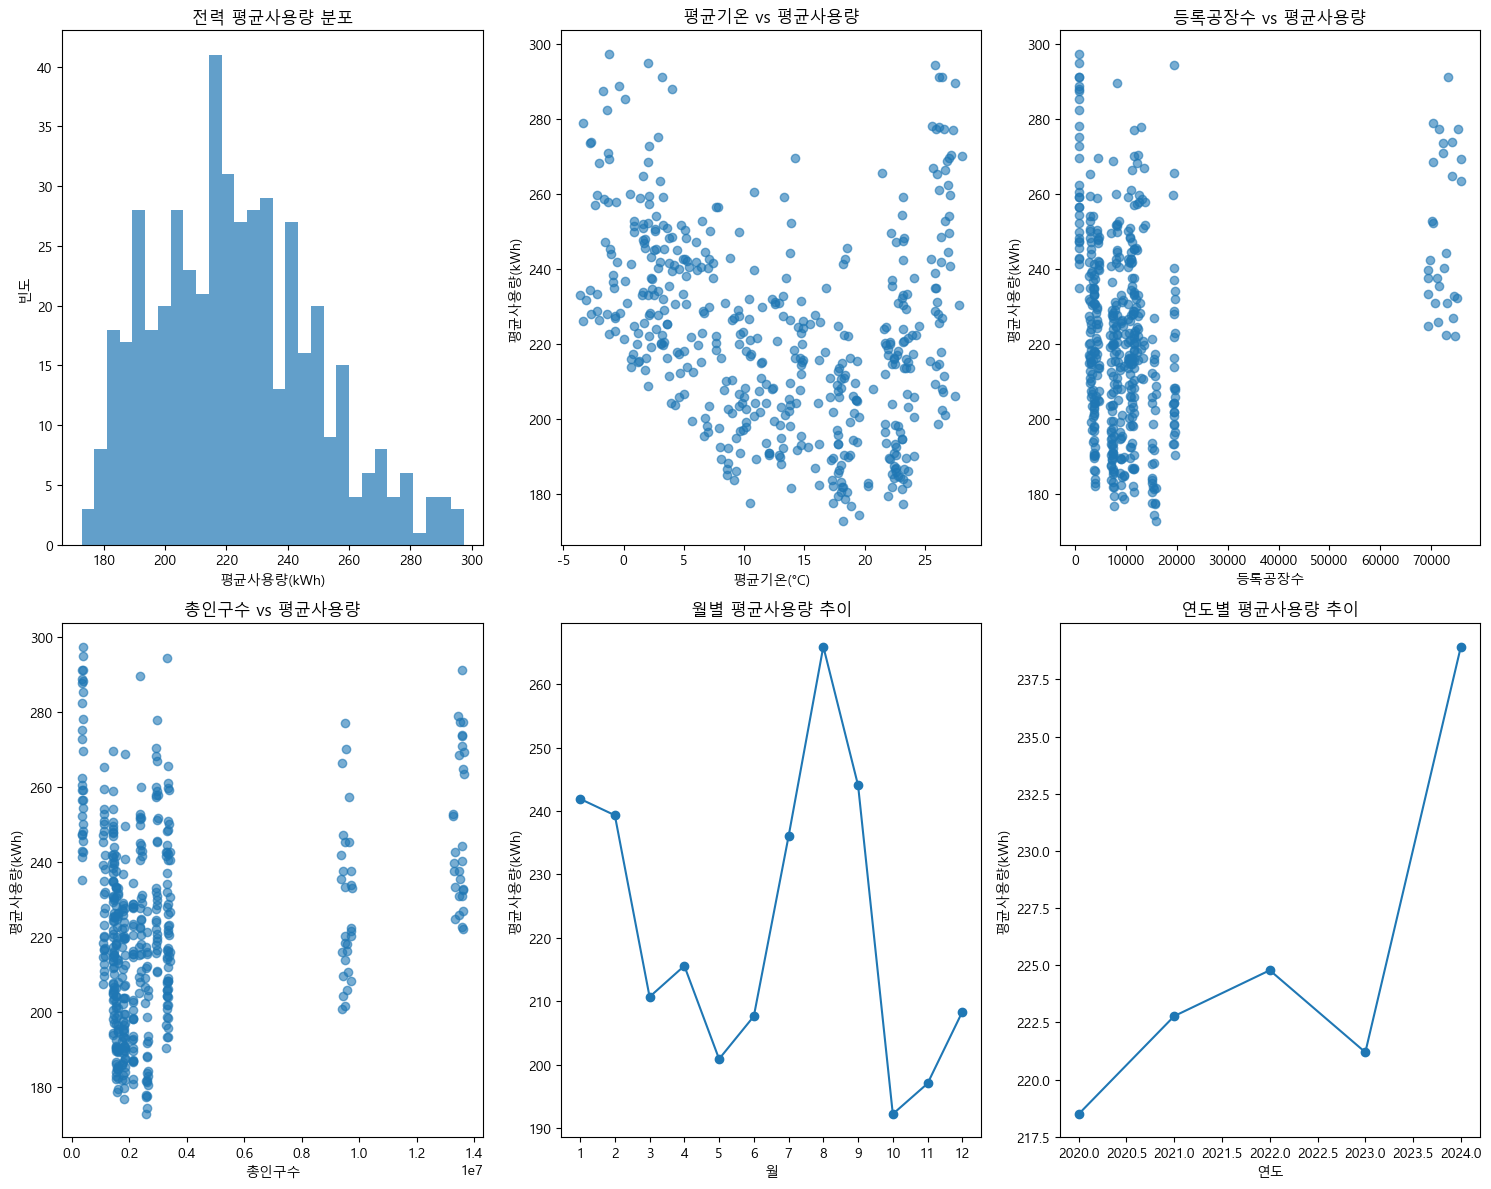

In [28]:
# 데이터 시각화
plt.figure(figsize=(15, 12))

# 1. 평균사용량 분포
plt.subplot(2, 3, 1)
plt.hist(merged_df['평균사용량'], bins=30, alpha=0.7)
plt.title('전력 평균사용량 분포')
plt.xlabel('평균사용량(kWh)')
plt.ylabel('빈도')

# 2. 평균기온과 평균사용량의 관계
plt.subplot(2, 3, 2)
plt.scatter(merged_df['평균기온'], merged_df['평균사용량'], alpha=0.6)
plt.title('평균기온 vs 평균사용량')
plt.xlabel('평균기온(°C)')
plt.ylabel('평균사용량(kWh)')

# 3. 등록공장수와 평균사용량의 관계
plt.subplot(2, 3, 3)
plt.scatter(merged_df['등록공장수'], merged_df['평균사용량'], alpha=0.6)
plt.title('등록공장수 vs 평균사용량')
plt.xlabel('등록공장수')
plt.ylabel('평균사용량(kWh)')

# 4. 총인구수와 평균사용량의 관계
plt.subplot(2, 3, 4)
plt.scatter(merged_df['총인구수'], merged_df['평균사용량'], alpha=0.6)
plt.title('총인구수 vs 평균사용량')
plt.xlabel('총인구수')
plt.ylabel('평균사용량(kWh)')

# 5. 월별 평균사용량 추이
plt.subplot(2, 3, 5)
monthly_avg = merged_df.groupby('월')['평균사용량'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('월별 평균사용량 추이')
plt.xlabel('월')
plt.ylabel('평균사용량(kWh)')
plt.xticks(range(1, 13))

# 6. 연도별 평균사용량 추이
plt.subplot(2, 3, 6)
yearly_avg = merged_df.groupby('연')['평균사용량'].mean()
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title('연도별 평균사용량 추이')
plt.xlabel('연도')
plt.ylabel('평균사용량(kWh)')

plt.tight_layout()
plt.show()

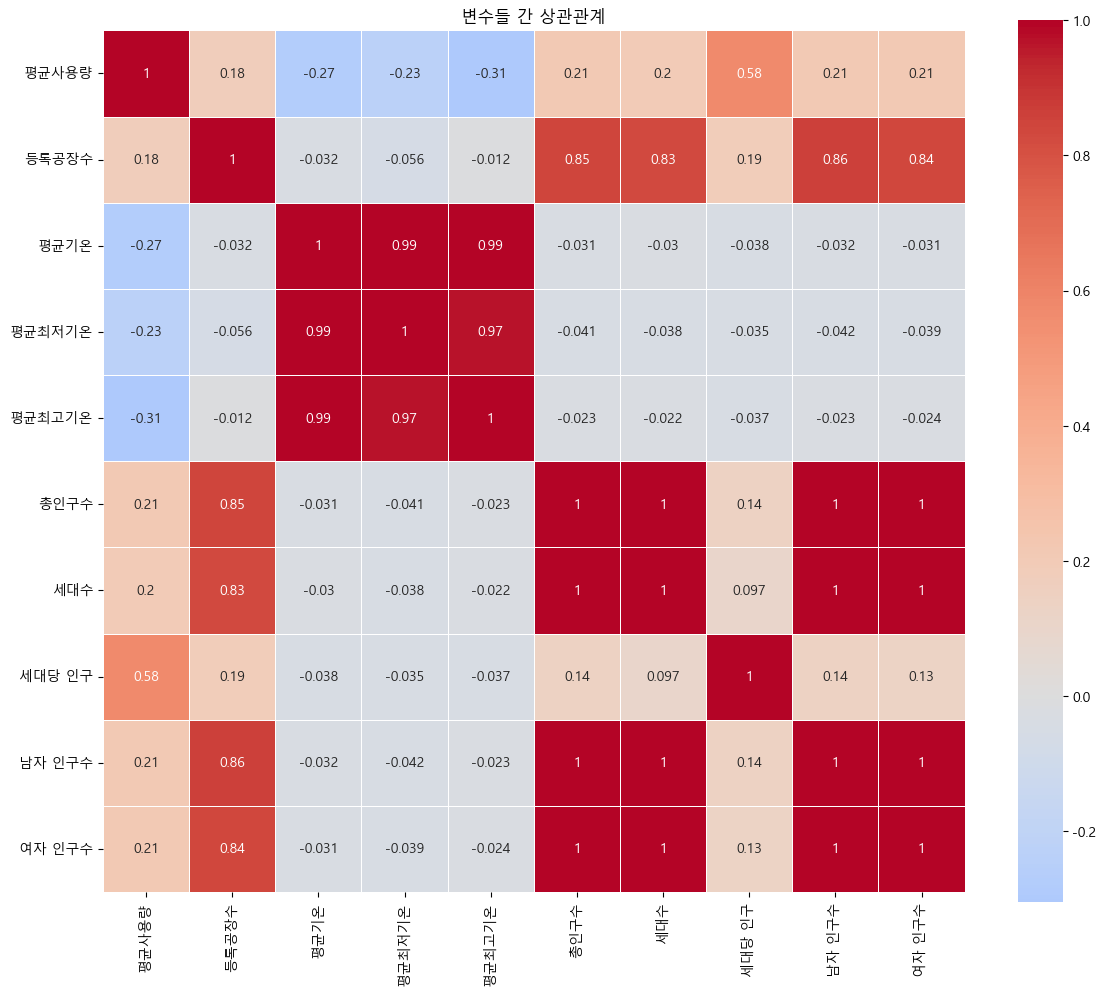


평균사용량과의 상관관계 (절댓값 기준):
평균사용량     1.000000
세대당 인구    0.575028
평균최고기온    0.305374
평균기온      0.272668
평균최저기온    0.228454
여자 인구수    0.212818
총인구수      0.212350
남자 인구수    0.211768
세대수       0.195230
등록공장수     0.177823
Name: 평균사용량, dtype: float64


In [29]:
# 상관관계 분석
# 수치형 변수들만 선택
numeric_cols = ['평균사용량', '등록공장수', '평균기온', '평균최저기온', '평균최고기온', 
                '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수']

corr_matrix = merged_df[numeric_cols].corr()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('변수들 간 상관관계')
plt.tight_layout()
plt.show()

# 평균사용량과의 상관관계 정렬
power_corr = corr_matrix['평균사용량'].abs().sort_values(ascending=False)
print("\n평균사용량과의 상관관계 (절댓값 기준):")
print(power_corr)

In [30]:
# 독립변수
feature_cols = ['등록공장수', '평균기온', '평균최저기온', '평균최고기온', 
                '총인구수', '세대수', '세대당 인구', '연', '월']

X = merged_df[feature_cols].copy()
y = merged_df['평균사용량'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 데이터 정규화 (StandardScaler 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
train_rmse_xgb = np.sqrt(train_mse_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print("\n훈련 데이터:")
print(f"R²: {train_r2_xgb:.4f}, RMSE: {train_rmse_xgb:.2f}, MAE: {train_mae_xgb:.2f}")

print(f"\n테스트 데이터:")
print(f"R²: {test_r2_xgb:.4f}, RMSE: {test_rmse_xgb:.2f}, MAE: {test_mae_xgb:.2f}")


훈련 데이터:
R²: 0.9993, RMSE: 0.72, MAE: 0.53

테스트 데이터:
R²: 0.8032, RMSE: 10.95, MAE: 5.86


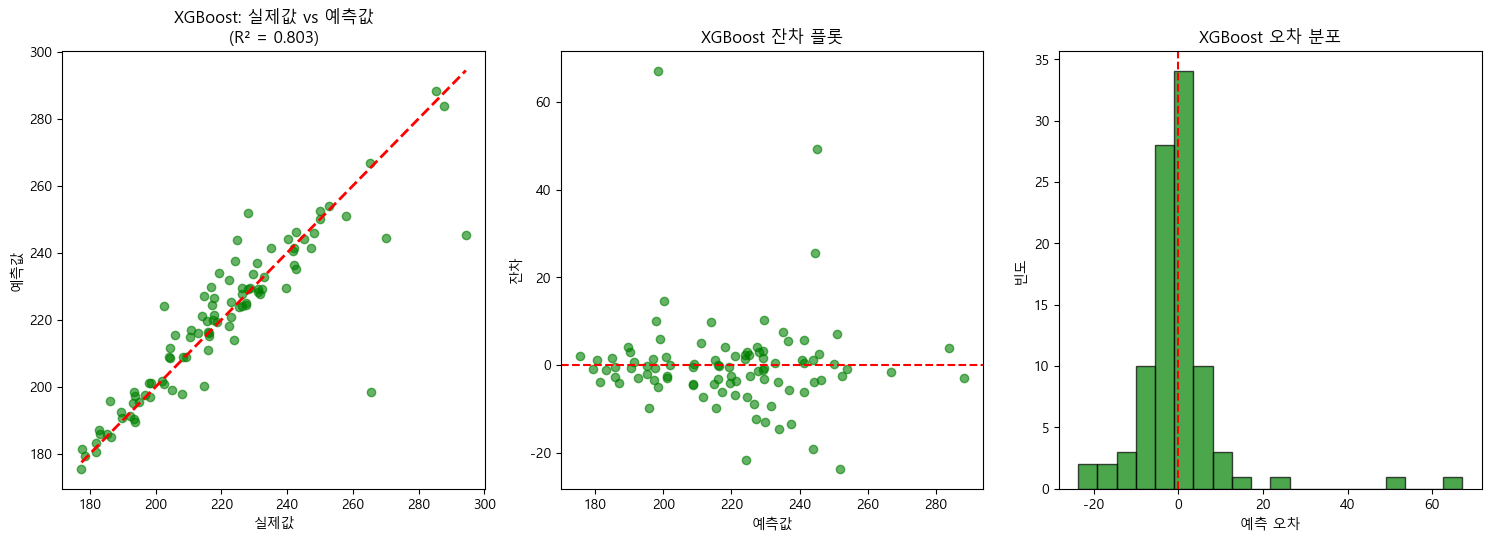

In [34]:
# XGBoost 모델 결과 시각화
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title(f'XGBoost: 실제값 vs 예측값\n(R² = {test_r2_xgb:.3f})')

plt.subplot(3, 4, 2)
residuals_test_xgb = y_test - y_test_pred_xgb
plt.scatter(y_test_pred_xgb, residuals_test_xgb, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.title('XGBoost 잔차 플롯')

plt.subplot(3, 4, 3)
plt.hist(residuals_test_xgb, bins=20, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('예측 오차')
plt.ylabel('빈도')
plt.title('XGBoost 오차 분포')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [35]:
print(f"\n모델 성능:")
print(f"   - 결정계수(R²): {test_r2_xgb:.3f} (전력사용량 변동의 {test_r2_xgb*100:.1f}%를 설명)")
print(f"   - 평균 절대 오차(MAE): {test_mae_xgb:.2f} kWh")
print(f"   - 평균 제곱근 오차(RMSE): {test_rmse_xgb:.2f} kWh")


모델 성능:
   - 결정계수(R²): 0.803 (전력사용량 변동의 80.3%를 설명)
   - 평균 절대 오차(MAE): 5.86 kWh
   - 평균 제곱근 오차(RMSE): 10.95 kWh


In [36]:
def predict_power_usage_advanced(등록공장수, 평균기온, 평균최저기온, 평균최고기온, 
                                총인구수, 세대수, 세대당인구, 연, 월):
    # 입력 데이터 준비
    new_data = np.array([[등록공장수, 평균기온, 평균최저기온, 평균최고기온, 
                         총인구수, 세대수, 세대당인구, 연, 월]])
    
    # 정규화
    new_data_scaled = scaler.transform(new_data)
    
    prediction = xgb_model.predict(new_data_scaled)[0]
    return prediction

def compare_model_predictions(등록공장수, 평균기온, 평균최저기온, 평균최고기온, 
                            총인구수, 세대수, 세대당인구, 연, 월):
    xgb_pred = predict_power_usage_advanced(등록공장수, 평균기온, 평균최저기온, 평균최고기온, 
                                          총인구수, 세대수, 세대당인구, 연, 월)
    
    return xgb_pred

sample_data = merged_df.iloc[0]  # 첫 번째 데이터 사용

xgb_predicted = compare_model_predictions(
    등록공장수=sample_data['등록공장수'],
    평균기온=sample_data['평균기온'],
    평균최저기온=sample_data['평균최저기온'],
    평균최고기온=sample_data['평균최고기온'],
    총인구수=sample_data['총인구수'],
    세대수=sample_data['세대수'],
    세대당인구=sample_data['세대당 인구'],
    연=sample_data['연'],
    월=sample_data['월']
)

actual_value = sample_data['평균사용량']

print(f"실제값: {actual_value:.2f} kWh")
print(f"XGBoost 예측값: {xgb_predicted:.2f} kWh (오차: {abs(xgb_predicted - actual_value):.2f} kWh)")

실제값: 217.75 kWh
XGBoost 예측값: 221.42 kWh (오차: 3.67 kWh)


c:\Users\joonsu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
